<a href="https://colab.research.google.com/github/gpapadok/gan-pytorch-mnist/blob/master/dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [2]:
# PARAMETERS
LR = .0002
BETA1 = .5
BETA2 = .999
BATCH_SIZE = 128

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((.5,), (.5,))
     ])

try:
  trainset = torchvision.datasets.MNIST('./data', transform=transform)
  # testset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform)
except RuntimeError:
  trainset = torchvision.datasets.MNIST('./data', download=True, transform=transform)
  # testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
# print(trainset)
# print(testset)

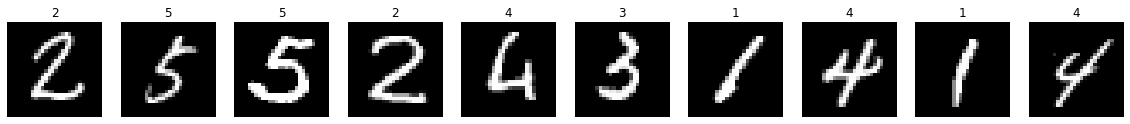

In [5]:
def plot_digits(dataset):
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
  trainiter = iter(trainloader)
  batch = trainiter.next()

  fig = plt.figure(figsize=(20,200))
  for j in range(10):
    plt.subplot(1,10,j+1)
    plt.imshow(batch[0][j][0,:], cmap='gray')
    plt.title(batch[1][j].item())
    plt.axis('off')

plot_digits(trainset)

In [6]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.conv1 = nn.ConvTranspose2d(100, 512, 5)
    self.bn1 = nn.BatchNorm2d(512)
    self.conv2 = nn.ConvTranspose2d(512, 128, 4)
    self.bn2 = nn.BatchNorm2d(128)
    self.conv3 = nn.ConvTranspose2d(128, 64, 4)
    self.bn3 = nn.BatchNorm2d(64)
    self.conv4 = nn.ConvTranspose2d(64, 32, 5, 2)
    self.bn4 = nn.BatchNorm2d(32)
    self.conv5 = nn.ConvTranspose2d(32, 1, 4)

    self.leaky_relu = nn.LeakyReLU(.2)

  def forward(self, input):
    x = input.view(-1, 100, 1, 1)
    x = self.bn1(self.conv1(x))
    x = self.leaky_relu(x)
    x = self.bn2(self.conv2(x))
    x = self.leaky_relu(x)
    x = self.bn3(self.conv3(x))
    x = self.leaky_relu(x)
    x = self.bn4(self.conv4(x))
    x = self.leaky_relu(x)
    x = self.conv5(x)

    return torch.tanh(x)

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 5)
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32, 64, 4)
    self.bn2 = nn.BatchNorm2d(64)
    self.conv3 = nn.Conv2d(64, 128, 4)
    self.bn3 = nn.BatchNorm2d(128)
    self.conv4 = nn.Conv2d(128, 256, 5, 2)
    self.bn4 = nn.BatchNorm2d(256)
    self.fc = nn.Linear(256 * 7 * 7, 1)

    self.leaky_relu = nn.LeakyReLU(.2)

  def forward(self, input):
    x = self.bn1(self.conv1(input))
    x = self.leaky_relu(x)
    x = self.bn2(self.conv2(x))
    x = self.leaky_relu(x)
    x = self.bn3(self.conv3(x))
    x = self.leaky_relu(x)
    x = self.bn4(self.conv4(x))
    x = self.leaky_relu(x)
    x = self.fc(x.view(-1, 256 * 7 * 7))
    return torch.sigmoid(x)

In [7]:
class GAN():
  def __init__(self, generator, discriminator, loss, optimizerG, optimizerD, batch_size=BATCH_SIZE):
    self.generator = generator
    self.discriminator = discriminator
    self.loss = loss
    self.optimG = optimizerG
    self.optimD = optimizerD
    self.batch_size = batch_size

  def generate_fake(self, batch):
    return self.generator(batch)

  def plot_ten_samples(self):
    noise = torch.randn(10, 100, device=device)
    fake = self.generate_fake(noise).cpu()
    fake = fake.detach().numpy()

    fig = plt.figure(figsize=(20,200))
    for j in range(10):
      plt.subplot(1,10,j+1)
      plt.imshow(fake[j][0], cmap='gray')
      plt.axis('off')
    plt.show()

  def train(self, trainset, epochs, verbose=True):
    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=self.batch_size, shuffle=True)

    errG_history = []
    errD_history = []
    try:
      for epoch in range(epochs):
        if epoch % 5 == 0:
          self.plot_ten_samples()
        for j, data in enumerate(trainloader, 0):
          # TRAIN DISCRIMINATOR
          for _ in range(1):
            self.optimD.zero_grad()

            # Train with real
            real = data[0].to(device)
            batch_size = real.size()[0]
            real_labels = torch.ones(batch_size, 1, device=device) * .9
            out = self.discriminator(real)
            errD_real = self.loss(out, real_labels)
            errD_real.backward()

            # Train with fake
            noise = torch.randn(batch_size, 100, device=device)
            fake = self.generate_fake(noise)
            fake_labels = torch.ones(batch_size, 1, device=device) * .1
            out = self.discriminator(fake)
            errD_fake = self.loss(out, fake_labels)
            errD_fake.backward()

            self.optimD.step()

          errD_history += [errD_real+errD_fake]

          # TRAIN GENERATOR
          self.optimG.zero_grad()

          noise = torch.randn(batch_size, 100, device=device)
          fake = self.generate_fake(noise)
          fake_labels = torch.ones(batch_size, 1, device=device)
          out = self.discriminator(fake)
          errG = self.loss(out, fake_labels)
          errG.backward()

          self.optimG.step()

          errG_history += [errG]

        print(f'EPOCH {epoch+1:2}: Dloss {errD_history[-1]:.4f} Gloss {errG_history[-1]:.4f}')
    except KeyboardInterrupt:
      return errG_history, errD_history


          
    return errG_history, errD_history

In [8]:
dnet = Discriminator().to(device)
gnet = Generator().to(device)

# print(gnet)
# print(dnet)

In [9]:
loss = nn.BCELoss()
optimizerD = optim.Adam(dnet.parameters(), lr=LR, betas=(BETA1, BETA2))
optimizerG = optim.Adam(gnet.parameters(), lr=LR, betas=(BETA1, BETA2))

gan = GAN(gnet, dnet, loss, optimizerG, optimizerD)

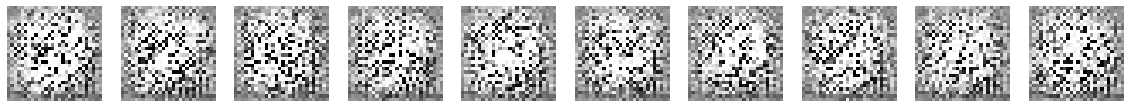

EPOCH  1: Dloss 0.7218 Gloss 2.2233
EPOCH  2: Dloss 0.9393 Gloss 1.3051
EPOCH  3: Dloss 0.8906 Gloss 1.4816
EPOCH  4: Dloss 0.7675 Gloss 1.7178
EPOCH  5: Dloss 0.9256 Gloss 1.9356


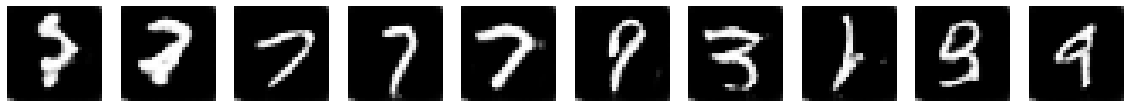

EPOCH  6: Dloss 0.7356 Gloss 1.5826
EPOCH  7: Dloss 0.8770 Gloss 1.9491
EPOCH  8: Dloss 0.8607 Gloss 1.5199
EPOCH  9: Dloss 0.7177 Gloss 1.6287
EPOCH 10: Dloss 0.8276 Gloss 1.9041


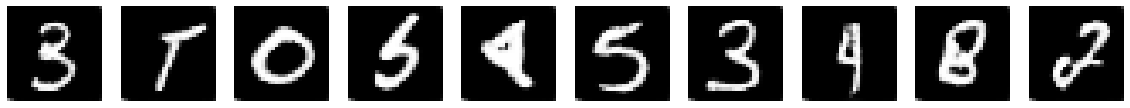

EPOCH 11: Dloss 0.9358 Gloss 2.4800
EPOCH 12: Dloss 0.7131 Gloss 1.6829
EPOCH 13: Dloss 0.7223 Gloss 2.8568
EPOCH 14: Dloss 0.7739 Gloss 2.1557
EPOCH 15: Dloss 0.8354 Gloss 1.4494


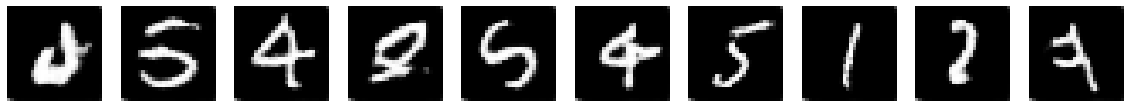

EPOCH 16: Dloss 0.7358 Gloss 1.9539
EPOCH 17: Dloss 0.7090 Gloss 1.1254
EPOCH 18: Dloss 0.9440 Gloss 2.0857
EPOCH 19: Dloss 0.7268 Gloss 2.4067
EPOCH 20: Dloss 0.7925 Gloss 2.1259


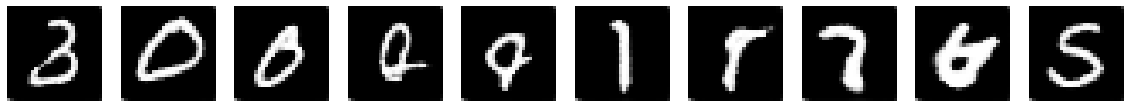

EPOCH 21: Dloss 0.7640 Gloss 1.6581
EPOCH 22: Dloss 1.3511 Gloss 1.2117
EPOCH 23: Dloss 0.8143 Gloss 1.6552
EPOCH 24: Dloss 0.7878 Gloss 1.1441
EPOCH 25: Dloss 0.7923 Gloss 1.8752


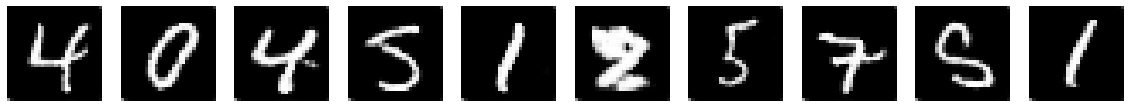

EPOCH 26: Dloss 3.8524 Gloss 4.7954
EPOCH 27: Dloss 0.7008 Gloss 2.3111
EPOCH 28: Dloss 0.7523 Gloss 1.6376
EPOCH 29: Dloss 0.7397 Gloss 2.0295
EPOCH 30: Dloss 1.0144 Gloss 2.7912


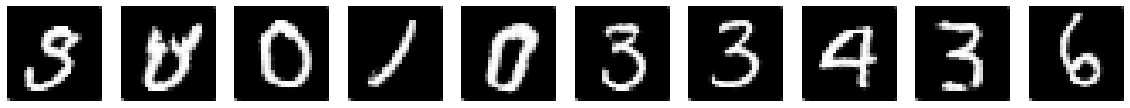

EPOCH 31: Dloss 0.7121 Gloss 1.9359
EPOCH 32: Dloss 0.7829 Gloss 2.1641
EPOCH 33: Dloss 0.7099 Gloss 2.5655
EPOCH 34: Dloss 0.7111 Gloss 1.9090
EPOCH 35: Dloss 0.7226 Gloss 1.8769


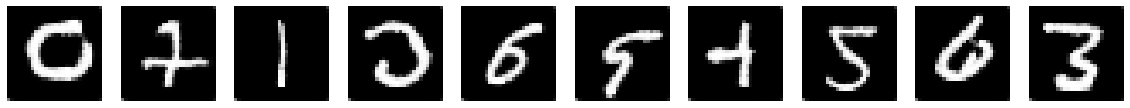

EPOCH 36: Dloss 0.8208 Gloss 1.6541
EPOCH 37: Dloss 0.9265 Gloss 2.4131
EPOCH 38: Dloss 0.7036 Gloss 1.7982
EPOCH 39: Dloss 0.6927 Gloss 1.9715
EPOCH 40: Dloss 0.7015 Gloss 2.6004


In [10]:
errorG_history, errorD_history = gan.train(trainset, epochs=40)

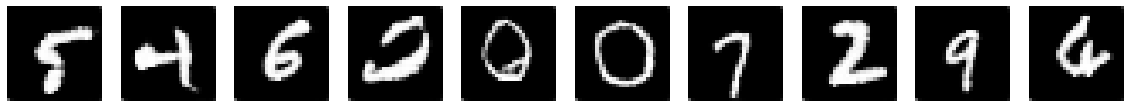

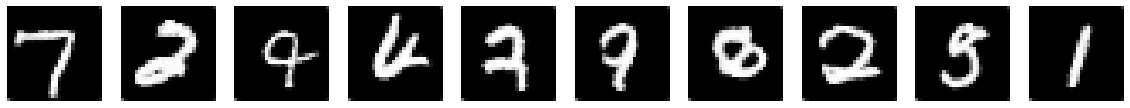

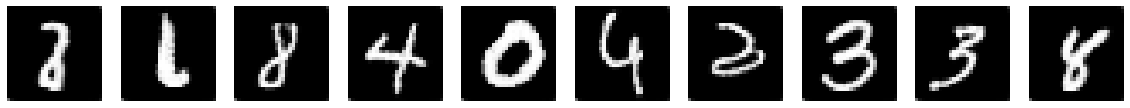

In [13]:
gan.plot_ten_samples()
gan.plot_ten_samples()
gan.plot_ten_samples()

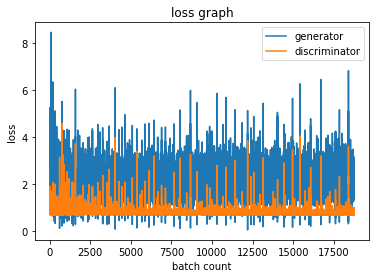

In [12]:
plt.plot(errorG_history)
plt.plot(errorD_history)
plt.title('loss graph')
plt.xlabel('batch count')
plt.ylabel('loss')
plt.legend(['generator','discriminator'])

In [14]:
torch.save(gan.generator.state_dict(), "dcgan.pt")